# Hospital Length of Stay Estimation at Admission

Import nessasory library and file

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso

data = pd.read_csv('/Users/lexiancheo/Downloads/AY24CBA/INF002v4.csv')

Handling missing values and datatypes

In [3]:
missing_values = data.isnull().sum()
print(missing_values)
data.drop(['Payment.Typology.2', 'Payment.Typology.3'], axis=1, inplace=True)

Hospital.Service.Area                     31
Age.Group                                  0
Gender                                     0
Race                                       0
Ethnicity                                  0
Length.of.Stay                             0
Type.of.Admission                          0
Patient.Disposition                        0
Discharge.Year                             0
CCSR.Diagnosis.Code                        0
CCSR.Diagnosis.Description                 0
APR.DRG.Code                               0
APR.DRG.Description                        0
APR.Severity.of.Illness.Code               0
APR.Severity.of.Illness.Description        1
APR.Risk.of.Mortality                      1
APR.Medical.Surgical.Description           0
Payment.Typology.1                         0
Payment.Typology.2                     11547
Payment.Typology.3                     23359
Emergency.Department.Indicator             0
Total.Charges                              0
Total.Cost

In [3]:
data.dtypes

Hospital.Service.Area                  object
Age.Group                              object
Gender                                 object
Race                                   object
Ethnicity                              object
Length.of.Stay                          int64
Type.of.Admission                      object
Patient.Disposition                    object
Discharge.Year                          int64
CCSR.Diagnosis.Code                    object
CCSR.Diagnosis.Description             object
APR.DRG.Code                            int64
APR.DRG.Description                    object
APR.Severity.of.Illness.Code            int64
APR.Severity.of.Illness.Description    object
APR.Risk.of.Mortality                  object
APR.Medical.Surgical.Description       object
Payment.Typology.1                     object
Emergency.Department.Indicator         object
Total.Charges                          object
Total.Costs                            object
dtype: object

In [4]:
#remove coma and turn string into float
data['Total.Charges'] = data['Total.Charges'].replace(',', '', regex=True).astype(float)
data['Total.Costs'] = data['Total.Costs'].replace(',', '', regex=True).astype(float)
data.dtypes

Hospital.Service.Area                   object
Age.Group                               object
Gender                                  object
Race                                    object
Ethnicity                               object
Length.of.Stay                           int64
Type.of.Admission                       object
Patient.Disposition                     object
Discharge.Year                           int64
CCSR.Diagnosis.Code                     object
CCSR.Diagnosis.Description              object
APR.DRG.Code                             int64
APR.DRG.Description                     object
APR.Severity.of.Illness.Code             int64
APR.Severity.of.Illness.Description     object
APR.Risk.of.Mortality                   object
APR.Medical.Surgical.Description        object
Payment.Typology.1                      object
Emergency.Department.Indicator          object
Total.Charges                          float64
Total.Costs                            float64
dtype: object

Data Exploration

In [5]:
los_summary = data['Length.of.Stay'].describe()

los_summary

count    28109.000000
mean         9.580597
std         11.183558
min          1.000000
25%          3.000000
50%          6.000000
75%         11.000000
max        120.000000
Name: Length.of.Stay, dtype: float64

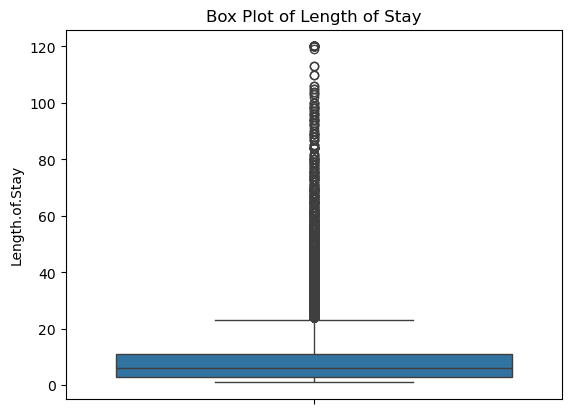

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot example
sns.boxplot(data['Length.of.Stay'])
plt.title('Box Plot of Length of Stay')
plt.show()


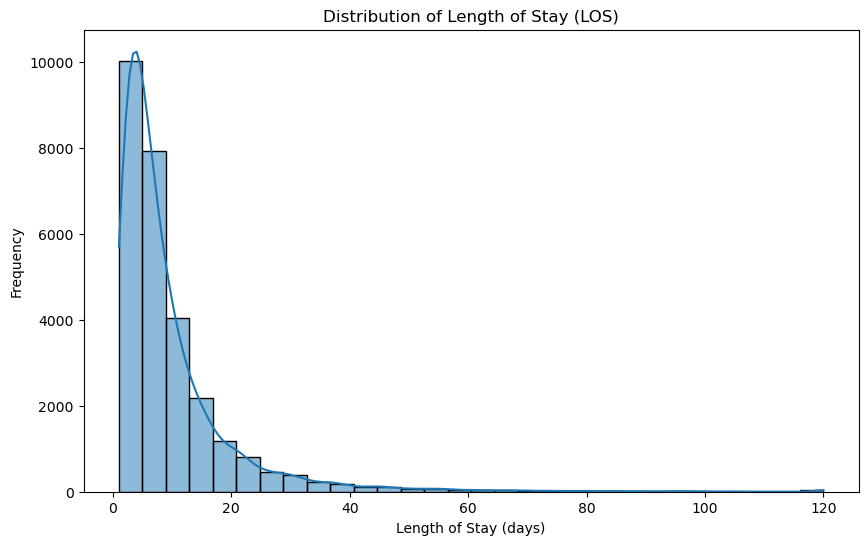

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Length.of.Stay'], bins=30, kde=True)
plt.title('Distribution of Length of Stay (LOS)')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

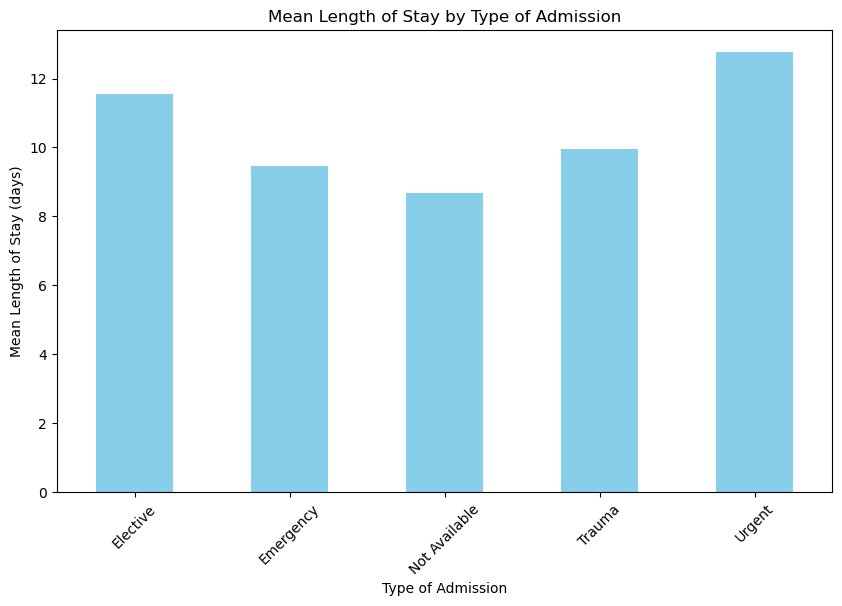

In [8]:
mean_los_by_admission = data.groupby('Type.of.Admission')['Length.of.Stay'].mean()

plt.figure(figsize=(10, 6))
mean_los_by_admission.plot(kind='bar', color='skyblue')
plt.title('Mean Length of Stay by Type of Admission')
plt.xlabel('Type of Admission')
plt.ylabel('Mean Length of Stay (days)')
plt.xticks(rotation=45)
plt.show()

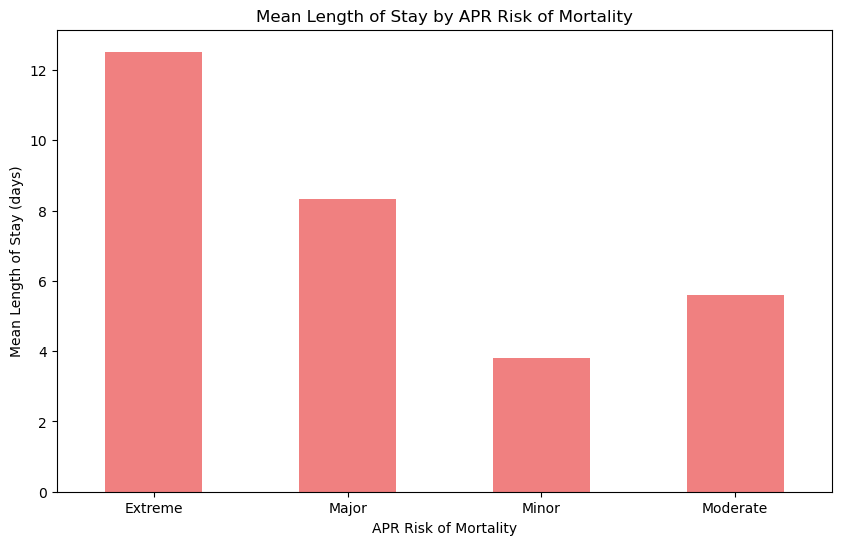

In [9]:
los_by_mortality = data.groupby('APR.Risk.of.Mortality')['Length.of.Stay'].mean()

plt.figure(figsize=(10, 6))
los_by_mortality.plot(kind='bar', color='lightcoral')
plt.title('Mean Length of Stay by APR Risk of Mortality')
plt.xlabel('APR Risk of Mortality')
plt.ylabel('Mean Length of Stay (days)')
plt.xticks(rotation=0)
plt.show()

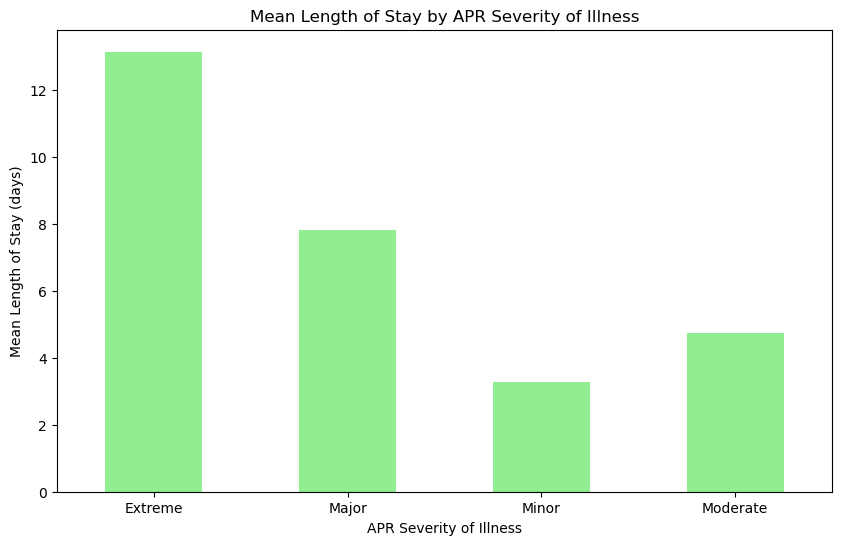

In [10]:
los_by_severity = data.groupby('APR.Severity.of.Illness.Description')['Length.of.Stay'].mean()

plt.figure(figsize=(10, 6))
los_by_severity.plot(kind='bar', color='lightgreen')
plt.title('Mean Length of Stay by APR Severity of Illness')
plt.xlabel('APR Severity of Illness')
plt.ylabel('Mean Length of Stay (days)')
plt.xticks(rotation=0)
plt.show()

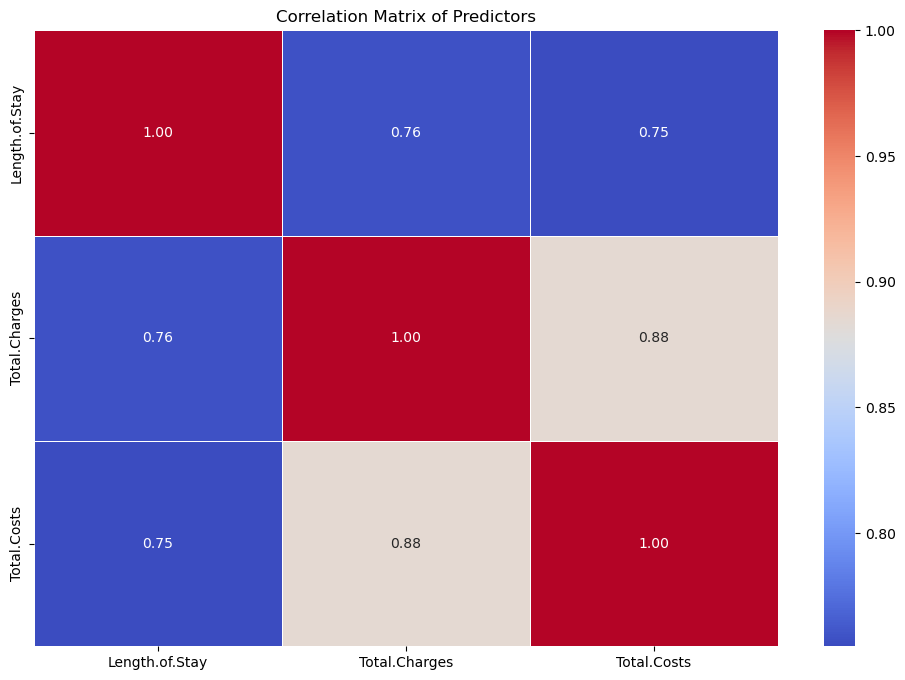

In [11]:
corr_set = data[['Length.of.Stay', 'Total.Charges', 'Total.Costs']]

# Compute the correlation matrix
corr_matrix = corr_set.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Predictors')
plt.show()

Build model

In [5]:
predictor_variables = [
    'Age.Group', 'Gender', 'Race', 'Ethnicity', 
    'Type.of.Admission', 'Patient.Disposition',
    'APR.DRG.Code', 'APR.Severity.of.Illness.Code', 
    'APR.Risk.of.Mortality', 'Payment.Typology.1',
    'Emergency.Department.Indicator'
]

X = data[predictor_variables]

#check the number of observations and variables in the dataset
num_observations = X.shape[0]
num_variables = X.shape[1]

num_observations, num_variables

(28109, 11)

In [6]:
#one-hot encoding
y = data['Length.of.Stay']
X_encoded = pd.get_dummies(X, columns=predictor_variables, drop_first=True)

#split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

#linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))

#CART Model
cart_model = DecisionTreeRegressor(random_state=42)
cart_model.fit(X_train, y_train)
y_pred_cart = cart_model.predict(X_test)
rmse_cart = np.sqrt(mean_squared_error(y_test, y_pred_cart))

rmse_linear, rmse_cart

(55887584.93263168, 10.98479195679974)

Optimize

In [7]:
from skopt import BayesSearchCV

In [15]:
# Optimizing Linear Regression using Lasso
lasso_model = Lasso(max_iter=5000)
param_space_lasso = {'alpha': (0.05, 0.1, 'log-uniform')}

lasso_bayes_search = BayesSearchCV(lasso_model, param_space_lasso, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)
lasso_bayes_search.fit(X_train, y_train)

best_lasso_bayes = lasso_bayes_search.best_estimator_

y_pred_lasso = best_lasso_bayes.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print(f"Lasso RMSE: {rmse_lasso:.2f}, Best alpha: {lasso_bayes_search.best_params_}")

Lasso RMSE: 8.97, Best alpha: OrderedDict([('alpha', 0.05)])


In [10]:
#optimizing CART
param_space_cart = {
    'max_depth': (1, 30),  
    'min_samples_split': (2, 20),  
    'min_samples_leaf': (1, 15), 
    'max_features': (0.5, 1.0, 'uniform')
}

cart_search = BayesSearchCV(cart_model, param_space_cart, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)
cart_search.fit(X_train, y_train)

best_cart = cart_search.best_estimator_
y_pred_best_cart = best_cart.predict(X_test)
rmse_best_cart = np.sqrt(mean_squared_error(y_test, y_pred_best_cart))

print(f"Best CART RMSE: {rmse_best_cart:.2f}, Best Params: {cart_search.best_params_}")

Best CART RMSE: 8.98, Best Params: OrderedDict([('max_depth', 30), ('max_features', 0.5), ('min_samples_leaf', 15), ('min_samples_split', 20)])


In [17]:
#comparing
num_X_variables = X_train.shape[1]
num_ori_cart_terminal_nodes = cart_model.get_n_leaves()
num_op_cart_terminal_nodes = best_cart.get_n_leaves()

comparison = pd.DataFrame({
    'Model': ['Lasso', 'Original CART', 'Optimized CART'],
    'RMSE': [rmse_lasso, rmse_cart, rmse_best_cart],
    'variables/nodes' : [num_X_variables, num_ori_cart_terminal_nodes, num_op_cart_terminal_nodes]
})

comparison

,Model,RMSE,variables/nodes
0,Lasso,8.969245,63
1,Original CART,10.984792,6079
2,Optimized CART,9.007519,106


In [18]:
r2_best_cart = r2_score(y_test, y_pred_best_cart)

print(r2_best_cart)

0.27088427049018005


expriment after reading the article

In [8]:
target_encoded_features = [
    'Age.Group', 'Gender', 'Race', 'Ethnicity', 
    'Type.of.Admission', 'Patient.Disposition',
    'APR.DRG.Code', 'APR.Severity.of.Illness.Code', 
    'APR.Risk.of.Mortality', 'Payment.Typology.1',
    'Emergency.Department.Indicator'
]

los_data = data.copy()

#create mean and median
for feature in target_encoded_features:
    
    mean_encoded = los_data.groupby(feature)['Length.of.Stay'].mean()
    median_encoded = los_data.groupby(feature)['Length.of.Stay'].median()
    
    product_encoded = mean_encoded * median_encoded
    
    los_data[f"{feature}_product_encoded"] = los_data[feature].map(product_encoded)

los_data = los_data.dropna()

#one-hot encoding
los_data_encoded = pd.get_dummies(los_data, drop_first=True)

X = los_data_encoded.drop(columns=['Length.of.Stay'])
y = los_data_encoded['Length.of.Stay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))

#CART Model
cart_model = DecisionTreeRegressor(random_state=42)
cart_model.fit(X_train, y_train)
y_pred_cart = cart_model.predict(X_test)
rmse_cart = np.sqrt(mean_squared_error(y_test, y_pred_cart))

rmse_linear, rmse_cart

(7.1078618862364165, 7.045967305534086)

In [20]:
#optimizing Linear Regression using Lasso
lasso_model = Lasso(max_iter=5000)

param_space_lasso = {'alpha': (0.01, 10, 'log-uniform')}

lasso_bayes_search = BayesSearchCV(lasso_model, param_space_lasso, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)
lasso_bayes_search.fit(X_train, y_train)

best_lasso_bayes = lasso_bayes_search.best_estimator_

y_pred_lasso = best_lasso_bayes.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print(f"Lasso RMSE: {rmse_lasso:.2f}, Best alpha: {lasso_bayes_search.best_params_}")

/opt/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01] before, using random point [3.1041885183279336]
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01] before, using random point [0.17121477793974613]
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01] before, using random point [0.20416790512542698]
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01] before, using random point [0.30904726037728747]
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01] before, using random point [1.3985278

Lasso RMSE: 7.11, Best alpha: OrderedDict([('alpha', 0.01)])


In [9]:
#optimizing CART
param_space_cart = {
    'max_depth': (1, 30),  
    'min_samples_split': (2, 20),  
    'min_samples_leaf': (1, 15),  
    'max_features': (0.5, 1.0, 'uniform') 
}

cart_search = BayesSearchCV(cart_model, param_space_cart, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)
cart_search.fit(X_train, y_train)

best_cart = cart_search.best_estimator_
y_pred_best_cart = best_cart.predict(X_test)
rmse_best_cart = np.sqrt(mean_squared_error(y_test, y_pred_best_cart))

print(f"Best CART RMSE: {rmse_best_cart:.2f}, Best Params: {cart_search.best_params_}")

/opt/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [12, 1.0, 15, 2] before, using random point [5, 0.9848131352506738, 4, 2]
  warnings.warn(


Best CART RMSE: 5.52, Best Params: OrderedDict([('max_depth', 30), ('max_features', 0.694145805475429), ('min_samples_leaf', 15), ('min_samples_split', 18)])


In [22]:
#compare
num_X_variables = X_train.shape[1]
num_ori_cart_terminal_nodes = cart_model.get_n_leaves()
num_op_cart_terminal_nodes = best_cart.get_n_leaves()

comparison = pd.DataFrame({
    'Model': ['Original Linear Regression', 'Lasso', 'Original CART', 'Optimized CART'],
    'RMSE': [rmse_linear, rmse_lasso, rmse_cart, rmse_best_cart],
    'variables/nodes' : [num_X_variables, num_X_variables, num_ori_cart_terminal_nodes, num_op_cart_terminal_nodes]
})

comparison

,Model,RMSE,variables/nodes
0,Original Linear Regression,7.107862,84
1,Lasso,7.107213,84
2,Original CART,7.045967,14984
3,Optimized CART,5.518809,1136


In [23]:
r2_best_cart = r2_score(y_test, y_pred_best_cart)

print(r2_best_cart)

0.7542502373951887


In [1]:
from sklearn.tree import plot_tree

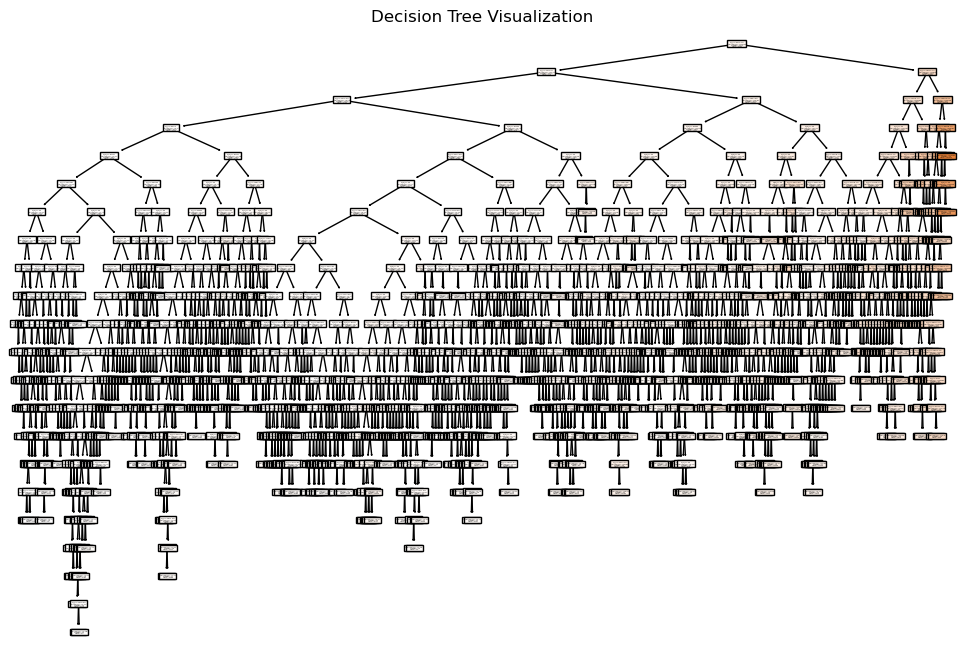

In [15]:

plt.figure(figsize=(12, 8))
plot_tree(best_cart, filled=True)
plt.title("Decision Tree Visualization")
plt.show()